# CNN-lytical Assignment-2
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will build a classifier for MNIST from using [PyTorch](https://pytorch.org/docs/stable/index.html). 

*   We will be using the same dataset as the previous assignment for MNIST. **Do not** use the complete MNIST dataset, even though PyTorch makes it really easy.

*   No limitations on your model this time, just don't use CNNs now, that's up next week.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Also remember to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch.

In [1]:
import torch as pt
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
np.random.seed(0) 

## Load *Dataset*
Use the pickle file shared for the previous assignment here.

In [18]:
data = pkl.load(open('train_data.pkl','rb'))
# print(data.keys())
X = pt.tensor(data['X']).float()
y = pt.tensor(data['y']).float()
valToScores = lambda val:np.vectorize(lambda x: 1 if x==val else 0)
aranged = np.arange(10)#[1,2,...,10]
scoreArray  =np.apply_along_axis(
    lambda y_elem:valToScores(y_elem)(aranged),
    1,
    y
)
y=pt.from_numpy(scoreArray).float()
print(X.shape,y.shape)
k = 1024*32
X_train = X[:k]
Y_train = y[:k]
X_test = X[k:2*k]
Y_test = y[k:2*k]
hls = 256
imgdim = 784
numdigs = 10

torch.Size([60000, 784]) torch.Size([60000, 10])


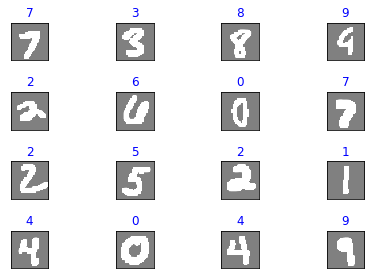

In [3]:
selection = np.random.choice(np.arange(X_train.shape[0]),size=16)
selImages = X_train[selection].numpy()
selLabels = Y_train[selection].numpy()
fig,axs = plt.subplots(4,4)
fig.tight_layout()
from typing import List
# axs:List[plt.Axes]
# axs[0].imshow()
for i in range(4):
    for j in range(4):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].imshow(selImages[4*i+j].reshape(28,28),cmap='gray',vmin=-1,vmax=1)
        axs[i,j].set_title(selLabels[4*i+j].argsort()[-1],color='blue')
plt.show()

## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).


**Note** - Things like normalization, augmentation etc. which are related to the dataset are all done in this class. However, because this assignment doesn't deal with MNIST images but rather feature vectors, this part is being skipped here and will be discussed in Assignment 3.

In [20]:
# define your dataset class
class Dataset:
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.Y)
    def __getitem__(self, i):
        if(i<len(self.Y)):
            return self.X[i],self.Y[i]
train_data = Dataset(X_train,Y_train)
test_data = Dataset(X_test,Y_test)
print(Y_test.shape)
trainDataLoader = DataLoader(train_data,batch_size=64,shuffle=True)
testDataLoader = DataLoader(test_data,batch_size=50,shuffle=True)


torch.Size([27232, 10])



## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [```nn.ReLU```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [```nn.BatchNorm1d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


In [5]:
class MaNet(pt.nn.Module):
    def __init__(self,imgdims,hdls,nmdigs):
        super(MaNet,self).__init__()
        self.linear1 = pt.nn.Linear(imgdims,hdls,bias=True)
        self.relu1 = pt.nn.ReLU()
        self.normalize1 = pt.nn.BatchNorm1d(hdls)
        self.linear2 = pt.nn.Linear(hdls,nmdigs,bias=True)
        self.relu2 = pt.nn.ReLU()
        self.normalize2 = pt.nn.BatchNorm1d(nmdigs)
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.normalize1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.normalize2(x)
        return x


## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [6]:
def train(model:MaNet, optimizer:pt.optim.SGD, criterion, train_loader:DataLoader,epochs=100, display_step=None):
    for i in range(epochs):
        lossData = []
        for j,data in enumerate(train_loader,0):
            indata,target = data
            # print(indata,type(indata))
            optimizer.zero_grad()
            output = model(indata)
            loss = criterion(output,target)
            lossData.append(loss.item())
            model.zero_grad()
            loss.backward()
            optimizer.step()
        print(np.average(lossData))
    return lossData,model


## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [7]:
def init_weights():
    pass

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [8]:
def predict(model, X_test):
    output = model(X_test)
    return output

In [9]:
def accuracy(pred, labels):
    labelsFlat = labels.numpy().argsort(axis=1)[:,-1].transpose()
    return np.round(100*np.where(
            labelsFlat
            ==
            pred.detach().numpy().argsort(axis=1)[:,-1]
            )[0].shape[0]/labelsFlat.shape[0])

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [12]:
model = MaNet(imgdim,hls,numdigs)
optimizer = pt.optim.SGD(model.parameters(),lr=0.01)
criterion = pt.nn.MSELoss()
lossdata, newModel= train(model,optimizer,criterion,trainDataLoader,epochs=2)
# lossdata, newModel= train(newModel,optimizer,criterion,trainDataLoader,epochs=2)


0.29918045028171036
0.05449119066543062
0.027351877261025948
0.023271281042980263


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [19]:
i = 0
for j,data in enumerate(testDataLoader):
        testd,testlabs= data
        print(testlabs.size(),type(testlabs))
        output = predict(newModel,testd)
        loss = pt.nn.MSELoss()(output,testlabs)
        acc = accuracy(output,testlabs)
        print(f"Loss on {j} test Data:{loss.item()}; Acc:{acc}")
        i+=1
        break

torch.Size([50, 10]) <class 'torch.Tensor'>
Loss on 0 test Data:0.028005382046103477; Acc:86.0


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_2.pt``` model-weights file to the repository.

In [74]:
# from google.colab import files
pt.save(newModel, 'ass_2.pt')
# files.download('ass_2.pt') # download the file from the Colab session for submission

Check if it got saved right!

In [75]:
# load the model, use predict function
model = pt.load('ass_2.pt')
for data in testDataLoader:
    testB1,testL1 = data
    output = predict(newModel,testB1)
    acc = accuracy(output,testL1)
    print(acc)
    break

98.0
